In [2]:
import numpy as np
import rocketcea
import matplotlib.pyplot as plt
import scipy as sp
import plotly.express as px
import pandas as pd
import CoolProp as CP
import CoolProp.CoolProp as CPP


In [3]:
from rocketcea.cea_obj_w_units import CEA_Obj

#Engine Definition and Unit Adjustment
C = CEA_Obj(
    oxName='LOX',
    fuelName='RP1',

    pressure_units='Pa',
    temperature_units='K',

    isp_units='m/s',              
    cstar_units='m/s',
    sonic_velocity_units='m/s',

    enthalpy_units='J/kg',
    specific_heat_units='J/kg-K',

    viscosity_units='millipoise', #10000 millipoise = 1 Pa*s
    thermal_cond_units='W/cm-degC', #1 W/cm*k = 100 W/m*k

    density_units='kg/m^3'
)

def EngineProp(P_c, OF, Thrust):
    
    g = 9.81 #Gravitational Acceleration [m/s^2]
    R = 8.314 #Universal Gas Constant [J/mol*K]
    pi = 3.14159265359
    P_e = 101325 #Atmospheric Pressure
    
    #Expansion Ratio
    ER = C.get_eps_at_PcOvPe(Pc = P_c, MR = OF, PcOvPe = P_c/P_e, frozen = 1)

    M_cW, G_c = C.get_Chamber_MolWt_gamma(Pc = P_c, MR = OF, eps = ER)
    T_c, T_t, T_e = C.get_Temperatures(Pc = P_c, MR = OF, eps = ER, frozen = 1)
    Cp_c, mu_cW, k_cW, Pr_c = C.get_Chamber_Transport(Pc = P_c, MR = OF, eps = ER, frozen = 1)
    cstar = C.get_Cstar(Pc = P_c, MR = OF)

    #Unit Adjustment
    M_c = M_cW/1000
    mu_c = mu_cW/10000
    k_c = k_cW*100

    R_bar_c = R/M_c

    #Mass Flow Calculation
    Ma_e = C.get_MachNumber(Pc = P_c, MR = OF, eps = ER, frozen = 1)
    C_c, C_t, C_e = C.get_SonicVelocities(Pc = P_c, MR = OF, eps = ER, frozen = 1)
    m_dot = Thrust/(Ma_e*C_e)
    m_dot_p = m_dot/(1+OF)
    m_dot_ox = m_dot*(OF/(1+OF))

    #Engine Geometry
    A_t = ((P_c/(m_dot*(T_c**0.5)))*((G_c/R_bar_c)**0.5)*((G_c+1)/2)**(-(G_c+1)/(2*(G_c-1))))**-1 #Throat Area [m^2]
    A = 3*A_t #Chamber Area w/ Contraction Ratio = 3 [m^2]
    A_e = A_t*2.3435 #Exit Area [m^2]
    D_t = 2 * (A_t/pi)**(0.5) #Throat Diameter [m]
    D_c = 2 * (A/pi)**(0.5) #Chamber Diameter [m]
    D_e = 2 * (A_e/pi)**(0.5) #Exit Diameter [m]
    x_t2e = (D_e - D_t)/(2*np.tan(15/57.2958)) #Normal Distance between Throat and Exit
    x_c2t = (D_c - D_t)/(2*np.tan(45/57.2958)) #Normal Distance between Chamber and Throat
    return locals()

def EngineText(engine):
    print("Engine Set Point",
      "\nChamber Pressure =", engine["P_c"], "Pa",
      "\nOF Ratio =", engine["OF"],
      "\nThrust Set Point =", engine["Thrust"], "N")
    print("\nEngine Geometry",
      "\nA_t =", engine["A_t"], "#Throat Area [m^2]",
      "\nA =", engine["A"], "#Chamber Area w/ Contraction Ratio = 3 [m^2]",
      "\nA_e =", engine["A_e"], "#Exit Area [m^2]",
      "\nD_t =", engine["D_t"], "#Throat Diameter [m]",
      "\nD_c =", engine["D_c"], "#Chamber Diameter [m]",
      "\nD_e =", engine["D_e"], "#Exit Diameter [m]")
    print("\nMass Flow Parameters",
      "\nmdot_total =", engine["m_dot"],
      "\nmdot_p =", engine["m_dot_p"],
      "\nmdot_ox =", engine["m_dot_ox"])
    print("\nEngine Core Properties",
      "\nG_c =", engine["G_c"], "#Chamber Gas Specific Heat Ratio",
      "\nT_c =", engine["T_c"], "#Chamber Gas Temperature [K]",
      "\nM_c =", engine["M_c"], "#Chamber Gas Molecular Weight [kg/mol]",
      "\nR_bar_c =", engine["R_bar_c"], "#Chamber Gas Specific Gas Constant",

      "\n\nChamber Transport Properties",
      "\nCp_c =", engine["Cp_c"], "#Chamber Gas Specific Heat Capacity [J/kg*K]",
      "\nmu_c =", engine["mu_c"], "#Chamber Gas Viscosity [Pa*s]",
      "\nk_c =", engine["k_c"], "#Chamber Gas Conductivity [W/m*K]",
      "\nPr_c =", engine["Pr_c"], "#Chamber Gas Prandtl Number",

      "\n\nPerformance Parameters",
      "\ncstar =", engine["cstar"], "Characteristic Velocity [m/sec]")


In [4]:
#Universal Constants
g = 9.81 #Gravitational Acceleration [m/s^2]
R = 8.314 #Universal Gas Constant [J/mol*K]
pi = 3.14159265359 

P_c = 1241056.31

engine = EngineProp(P_c = P_c, OF = 1.4, Thrust = 2200)
A_t = engine["A_t"]
A = engine["A"]
A_e = engine["A_e"]
D_t = engine["D_t"]
D_c = engine["D_c"]
D_e = engine["D_e"]
x_t2e = engine["x_t2e"]
x_c2t = engine["x_c2t"]

m_dot_p = engine["m_dot_p"]
G_c = engine["G_c"]
T_c = engine["T_c"]
M_c = engine["M_c"]
R_bar_c = engine["R_bar_c"]
Cp_c = engine["Cp_c"]
mu_c = engine["mu_c"]
k_c = engine["k_c"]
Pr_c = engine["Pr_c"]
cstar = engine["cstar"]

r_u = 0.00635 #Throat Radius of Curvature [m]

EngineText(engine)


Engine Set Point 
Chamber Pressure = 1241056.31 Pa 
OF Ratio = 1.4 
Thrust Set Point = 2200 N

Engine Geometry 
A_t = 0.0013698291302637283 #Throat Area [m^2] 
A = 0.004109487390791185 #Chamber Area w/ Contraction Ratio = 3 [m^2] 
A_e = 0.0032101945667730477 #Exit Area [m^2] 
D_t = 0.04176267015148623 #Throat Diameter [m] 
D_c = 0.07233506656211436 #Chamber Diameter [m] 
D_e = 0.06393236010588955 #Exit Diameter [m]

Mass Flow Parameters 
mdot_total = 1.0624030676688039 
mdot_p = 0.4426679448620016 
mdot_ox = 0.6197351228068023

Engine Core Properties 
G_c = 1.265448838220798 #Chamber Gas Specific Heat Ratio 
T_c = 2286.2700450851576 #Chamber Gas Temperature [K] 
M_c = 0.016993169612256477 #Chamber Gas Molecular Weight [kg/mol] 
R_bar_c = 489.2554002405444 #Chamber Gas Specific Gas Constant 

Chamber Transport Properties 
Cp_c = 2243.2217712544652 #Chamber Gas Specific Heat Capacity [J/kg*K] 
mu_c = 7.162691549117233e-05 #Chamber Gas Viscosity [Pa*s] 
k_c = 0.3151010675315256 #Chamber G

In [5]:
#Propellant Properties
from CoolProp.CoolProp import AbstractState
AS = AbstractState("HEOS", "n-Dodecane")

def kero_density(T_p, P_p): #[kg/m^3]
    AS.update(CP.PT_INPUTS, P_p, T_p)
    return AS.rhomass()
def kero_conductivity(T_p, P_p): #[W/m*K]
    AS.update(CP.PT_INPUTS, P_p, T_p)
    return AS.conductivity()
def kero_viscosity(T_p, P_p): #[Pa*s]
    AS.update(CP.PT_INPUTS, P_p, T_p)
    return AS.viscosity()

In [6]:
#Function Definitions

def Bartz_Iterator(T_c, T_p, Ma, A, h_p, k_w, t_w):
    T_hw = 500 #Hot Wall Temperature Initial Guess [K]
    T_res = 1
    alpha = 0.3
    count = 0

    while T_res > 10e-6:
        #Update T_hw_old
        T_hw_old = T_hw

        #Bartz Calculation    
        r = Pr_c**0.33 #Recovery Factor
        T_aw = T_c * (((1+(r*(G_c-1)/2)*Ma**2))/((1+((G_c-1)/2)*Ma**2))) #Local Adiabatic Wall Temperature [K]
        s = 1/((((0.5*T_hw/T_c)*(1+((G_c-1)/2)*Ma**2)+0.5)**0.68)*(1+((G_c-1)/2)*Ma**2)**0.12) #Boundary Layer Correction Factor
        h_g = ((0.026/(D_t**0.2))*((Cp_c*mu_c**0.2)/(Pr_c**0.6))*(P_c/cstar)**0.8 * ((D_t/r_u)**0.1))*((A_t/A)**0.9)*s #Bartz Heat Transfer Coefficient [W/m^2*K]
        
        #Obtain new T_hw from Bartz
        q = h_g*(T_aw - T_hw)
        T_cw = (q/h_p) + T_p
        T_hw = q*t_w/k_w + T_cw

        #Under Relaxation
        T_hw = (1-alpha)*T_hw_old + alpha*T_hw
        T_res = abs(T_hw-T_hw_old)

        #count = count + 1
        #print(f"Count: {count}")
    return(T_hw, h_g, q, T_aw)

def Engine_Contour(L, x_c, x_t, x_e, D_c, D_t, D_e, n):
    #Initialize Lists
    x_list = np.linspace(0, L, n)
    D_list = []
    A_list = []

    for x in x_list:
        if x < x_c:
            D_list.append(D_c)
            A_list.append(pi*(D_c/2)**2)
        elif x >= x_c and x < x_t: 
            D = ((D_t - D_c)/(x_t - x_c))*(x - x_c) + D_c
            A = pi*(D/2)**2
            D_list.append(D)
            A_list.append(A)
        elif x >= x_t:
            D = ((D_e - D_t)/(x_e - x_t))*(x - x_t) + D_t
            A = pi*(D/2)**2
            D_list.append(D)
            A_list.append(A)

    r_list1 = [0.5 * D for D in D_list]
    r_list2 = [-0.5 * D for D in D_list]

    fig, ax = plt.subplots()
    ax.plot(x_list, r_list1, 'k-')
    ax.plot(x_list, r_list2, 'k-')
    ax.axis('equal')

    return(x_list, A_list)

def Regen(D_ch, L_ch, t_w, n, n_ch, m_dot_p, P_p, T_p0):
    
    #Propellant Properties
    AS.update(CP.PT_INPUTS, P_p, T_p0)

    mu_p = AS.viscosity()
    rho_p = AS.rhomass()
    k_p = AS.conductivity()
    Cp_p = AS.cp0mass()

    #Channel Parameters
    A_ch = pi*(D_ch/2)**2
    P_ch = 2*pi*D_ch
    #D_ch = (4*A_ch)/P_ch  #Hydraulic Diameter
    mdot_p = m_dot_p/n_ch
    v_p = mdot_p/(rho_p*A_ch)

    #Important Distances from Injector Face
    x_e = L_ch
    x_t = L_ch - x_t2e
    x_c = x_t - x_c2t

    #Initial Conditions
    T_p = T_p0
    Re = rho_p*v_p*D_ch/mu_p
    Pr = Cp_p*mu_p/k_p
    Nu = 0.023*(Re**(4/5))*(Pr**0.4)
    h_p = Nu*k_p/D_ch
    T_hw, h_g, q, T_aw = Bartz_Iterator(T_c = T_c, T_p = T_p, Ma = 0, A = A, h_p = h_p, k_w = 160, t_w = t_w) #hard coded values here, fix later
    dx = L_ch/n
    x_list, A_list = Engine_Contour(L = L_ch, x_c = x_c, x_t = x_t, x_e = L_ch, D_c = D_c, D_t = D_t, D_e = D_e, n = n) #hard coded values here, fix later
    x_index = 0

    #Initialize Lists for Plotting Later
    T_p_arr = []
    q_arr = []
    T_hw_arr = []
    h_g_arr = []

    #Propellant Heating
    for x in x_list:
        q_res = 1

        #Adjust dx for Path Length
        if x < x_c:
            ds = dx
        elif x >= x_c and x <= x_t:
            ds = dx/np.cos(45/57.2958)
        elif x > x_t:
            ds = dx/np.cos(15/57.2958)
        
        #Determine Local Area, Mach Number, and Combustion Gas Properties
        A_g = A_list[x_index]
        def f(Ma):
            return((1/Ma**2)*((2/(G_c+1))*(1 + ((G_c-1)*Ma**2)/2))**((G_c+1)/(G_c-1)) - A_g/A_t)
        if x < x_c:
            Ma = 0
        elif x >= x_c and x <= x_t:
            Ma = sp.optimize.brentq(f, 0.001, 1)
        elif x > x_t:
            Ma = sp.optimize.brentq(f, 1, 100)
        
        P = P_c * (1+((G_c-1)/2)*(Ma**2))**(-G_c/(G_c-1))
        #Set previous node's values
        T_p_prev = T_p
        q_prev = q

        # For every x position, run Bartz Loop and Heating Loop
        while q_res > 10e-6:
            
            #Update old values
            T_p_old = T_p
            q_old = q

            #Calculate Temperature Increment
            dT = q*P_ch*ds/(mdot_p*Cp_p)
            T_p = T_p_prev + dT

            #Establish New Material Properties
            T_pavg = (T_p_old + T_p)/2
            AS.update(CP.PT_INPUTS, P_p, T_pavg)

            mu_p = AS.viscosity()
            rho_p = AS.rhomass()
            k_p = AS.conductivity()
            Cp_p = AS.cp0mass()
            Re = rho_p*v_p*D_ch/mu_p
            Pr = Cp_p*mu_p/k_p
            Nu = 0.023*(Re**(4/5))*(Pr**0.4)
            h_p = Nu*k_p/D_ch

            T_hw, h_g, q, T_aw = Bartz_Iterator(T_c = T_c, T_p = T_p, Ma = Ma, A = A_g, h_p = h_p, k_w = 160, t_w = t_w) #hard coded values here, fix later

            q_res = abs(q-q_old)
        
        T_p_arr.append(T_p)
        q_arr.append(q)
        T_hw_arr.append(T_hw)
        h_g_arr.append(h_g)

        x_index = x_index + 1
    
    HWmax_index = np.argmax(T_hw_arr)
    x_hwmax = x_list[HWmax_index]
    T_hwmax = T_hw_arr[HWmax_index]
    print("Location of Max Hot Wall Temp", x_hwmax)
    print("Max Hot Wall Temp", T_hwmax)
    #Plottin
    
    #MatPlotLib
    #fig, ax = plt.subplots()
    #ax.plot(x_list, T_hw_arr)

    #Plotly
    df = pd.DataFrame(dict(x = x_list, T = T_hw_arr))
    fig = px.line(df, x = "x", y = "T", width = 600, height = 600)
    fig.update_layout(
        title=dict(
            text="Hot Wall Temperature vs Distance from Injector Face"
        ),
        xaxis=dict(
            title=dict(
                text="Distance from Injector Face (m)"
            )
        ),
        yaxis=dict(
            title=dict(
                text="Temperature (K)"
            )
        ),
)
    
    fig.show()


Location of Max Hot Wall Temp 0.12573499099099097
Max Hot Wall Temp 868.5236946477091


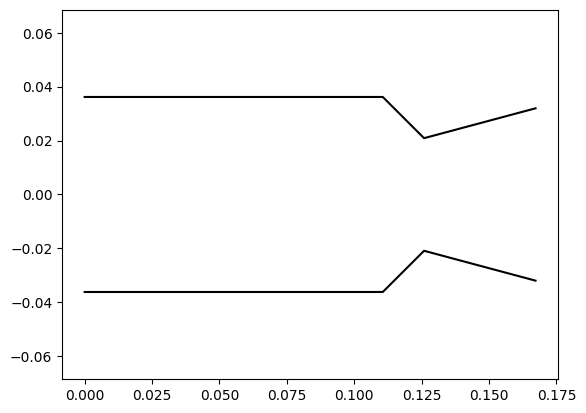

In [7]:
#Test Runs

#Bartz_Iterator(T_c = T_c, T_p = 330, Ma = 0, A = A, h_p = 17435.70437, k_w = 160, t_w = 0.007)

#Engine_Contour(L = 0.197256, x_c = 0.106230, x_t = 0.132530, x_e = 0.197256, D_c = 0.085725, D_t = 0.028956, D_e = 0.061760, n = 1000)

Regen(D_ch = 0.0027, L_ch = 0.167256, t_w = 0.0007, n = 1000, n_ch = 10, m_dot_p = 1.06,P_p = 1.24e6, T_p0 = 330)